# Setting Pyspark on Colab (If runned on colab)

In [1]:
!pip install pyspark
!pip install horovod[spark]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=451176eb9b35f04f1a69a4f5ede3e0b3c1d77ee6766aa402d1b9c0a6a6054551
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 34.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.0/284.0 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 5.1 MB/s eta 0:00:00
  Created wheel for horovod: filename=horovod-0.28.1-cp310-cp310-linux_x86_64.whl size=38034631 sha256=467200216683715d354577c8d41a2509b3ec8304688e6c0302cc88cf1558c39d
  Stored in directory: /root/.cache/pip/wheels/68

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [3]:
import os
import sys

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [4]:
!ls

diabetic_data.csv  sample_data	spark-3.1.1-bin-hadoop3.2  spark-3.1.1-bin-hadoop3.2.tgz


In [5]:
import findspark
findspark.init()

In [6]:
!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.2 MB/s eta 0:00:00
time: 1.01 ms (started: 2023-10-16 11:13:53 +00:00)


# Big Data Project: Diabetes Dataset

Taking some inspiration from:
- The paper of the dataset: https://downloads.hindawi.com/journals/bmri/2014/781670.pdf
- The data description attached with the dataset
- GitHub repo: https://github.com/ranveerkln/Diabetic/blob/main/dibetis_23_12.ipynb

## Import Libraries

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, max, count, sum, when, expr, lit
from pyspark.ml.feature import StringIndexer, StandardScaler, VectorAssembler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, MultilayerPerceptronClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, ClusteringEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.sql import SQLContext
from pandas import Series
from pyspark.ml.stat import Correlation
from pyspark.sql.types import IntegerType
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv1D, Dense, Dropout, Activation, MaxPooling1D, InputLayer, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
import horovod.spark.keras as hvd
from horovod.spark.common.store import DBFSLocalStore

seed = 42   # set the random seed

time: 14 s (started: 2023-10-16 11:13:53 +00:00)


## Get Dataset + Spark Session

In [8]:
df_pandas = pd.read_csv('diabetic_data.csv')

time: 1.47 s (started: 2023-10-16 11:14:07 +00:00)


In [9]:
df_pandas.head(10)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,...,No,Steady,No,No,No,No,No,No,Yes,>30
6,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
7,63768,114882984,Caucasian,Male,[70-80),?,1,1,7,5,...,No,No,No,No,No,No,No,No,Yes,>30
8,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
9,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


time: 61.4 ms (started: 2023-10-16 11:14:09 +00:00)


In [10]:
# local mode
spark = SparkSession.builder.appName('Project_BDA').getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

time: 12.6 s (started: 2023-10-16 11:14:09 +00:00)


In [11]:
df = spark.createDataFrame(df_pandas)

/content/spark-3.1.1-bin-hadoop3.2/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


time: 49.4 s (started: 2023-10-16 11:14:21 +00:00)


## Data Exploration


### Printing schema, shape and some interesting features

In [12]:
df.show(10)

+------------+-----------+---------------+------+--------+------+-----------------+------------------------+-------------------+----------------+----------+--------------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|           race|gender|     age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|   medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagn

In [13]:
df.printSchema()

root
 |-- encounter_id: long (nullable = true)
 |-- patient_nbr: long (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- weight: string (nullable = true)
 |-- admission_type_id: long (nullable = true)
 |-- discharge_disposition_id: long (nullable = true)
 |-- admission_source_id: long (nullable = true)
 |-- time_in_hospital: long (nullable = true)
 |-- payer_code: string (nullable = true)
 |-- medical_specialty: string (nullable = true)
 |-- num_lab_procedures: long (nullable = true)
 |-- num_procedures: long (nullable = true)
 |-- num_medications: long (nullable = true)
 |-- number_outpatient: long (nullable = true)
 |-- number_emergency: long (nullable = true)
 |-- number_inpatient: long (nullable = true)
 |-- diag_1: string (nullable = true)
 |-- diag_2: string (nullable = true)
 |-- diag_3: string (nullable = true)
 |-- number_diagnoses: long (nullable = true)
 |-- max_glu_serum: string (nullable = tru

In [14]:
# Dataset shape
print((df.count(), len(df.columns)))

(101766, 50)
time: 3.36 s (started: 2023-10-16 11:15:17 +00:00)


#### Visualization of some important features:  

In [15]:
df.select(['A1Cresult', 'readmitted']).show(15)

+---------+----------+
|A1Cresult|readmitted|
+---------+----------+
|     None|        NO|
|     None|       >30|
|     None|        NO|
|     None|        NO|
|     None|        NO|
|     None|       >30|
|     None|        NO|
|     None|       >30|
|     None|        NO|
|     None|        NO|
|     None|       >30|
|     None|       <30|
|     None|       <30|
|     None|        NO|
|     None|       >30|
+---------+----------+
only showing top 15 rows

time: 386 ms (started: 2023-10-16 11:15:20 +00:00)


Inspecting unique values for this two features

In [16]:
readmitted_unique = df.select("readmitted").distinct()
readmitted_unique.show()
A1Cresult_unique = df.select("A1Cresult").distinct()
A1Cresult_unique.show()

+----------+
|readmitted|
+----------+
|       >30|
|        NO|
|       <30|
+----------+

+---------+
|A1Cresult|
+---------+
|     None|
|       >8|
|     Norm|
|       >7|
+---------+

time: 7.84 s (started: 2023-10-16 11:15:20 +00:00)


Visualizing the none/null values

In [17]:
df.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '?' ) | \
                            col(c).isNull() | \
                            isnan(c), c
                           )).alias(c)
                    for c in df.columns]).show()

+------------+-----------+----+------+---+------+-----------------+------------------------+-------------------+----------------+----------+-----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|race|gender|age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_serum|A1Cresult|metformin

There are a lot of 'None' values in A1Cresult, but they are still important 'cause the indicate when the test was not performed. From this information we can gain as insight into whether or not the test is necessary

A lot of distinct in diag_x features, I must reduce values in data pre-processing section.

In [18]:
df.groupBy("diag_1").count().show

<bound method DataFrame.show of +------+-----+
|diag_1|count|
+------+-----+
|   296|  896|
|   691|    1|
|   451|   40|
|   853|   18|
|   800|    6|
|   944|    2|
|   870|    1|
|   919|    1|
|250.01|   61|
|   447|   63|
|   591|   19|
|     7|    2|
|   574|  965|
|   475|   14|
|   718|   17|
|   307|   25|
|   577| 1057|
|   581|   19|
|   205|   27|
|   747|    7|
+------+-----+
only showing top 20 rows
>

time: 3.64 s (started: 2023-10-16 11:15:44 +00:00)


In [19]:
df.groupBy("diag_2").count().show

<bound method DataFrame.show of +------+-----+
|diag_2|count|
+------+-----+
|   296|  165|
|   691|    3|
|   451|   32|
|   V72|   13|
|   800|    1|
|   944|    1|
|   853|    2|
|   919|    3|
|   870|    3|
|250.01| 1523|
|   447|   26|
|   591|  233|
|     7|    1|
|   574|  346|
|   718|   12|
|   307|   13|
|   475|    1|
|   577|  401|
|   581|   80|
|   205|   58|
+------+-----+
only showing top 20 rows
>

time: 2.21 s (started: 2023-10-16 11:15:48 +00:00)


In [20]:
df.groupBy("diag_3").count().show

<bound method DataFrame.show of +------+-----+
|diag_3|count|
+------+-----+
|   296|  214|
|   451|    9|
|  E876|    1|
|   V72|    8|
|   944|    1|
|   853|    1|
|   800|    2|
|   919|    3|
|   870|    2|
|250.01|  915|
|   591|  140|
|   447|   39|
|     7|    2|
|  E825|    1|
|   574|  136|
|   307|   16|
|   718|    9|
|   475|    1|
|   581|   97|
|   577|  149|
+------+-----+
only showing top 20 rows
>

time: 1.88 s (started: 2023-10-16 11:15:50 +00:00)


### Some plots to see distributions of readmission and presence of the test.

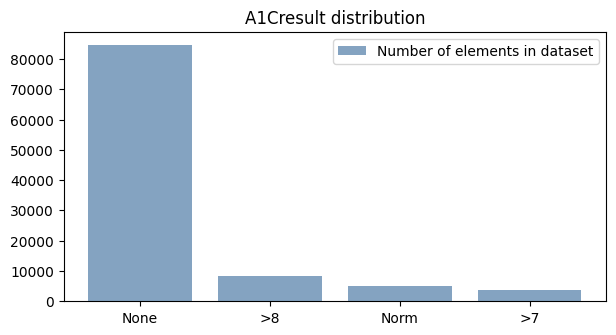

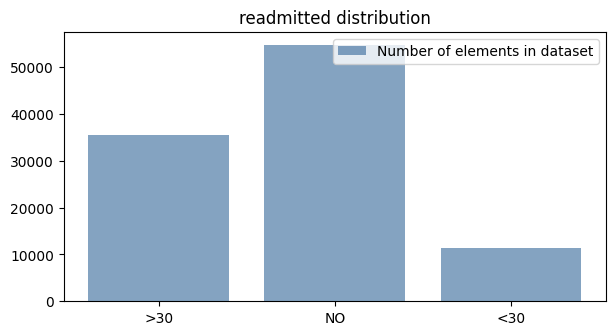



time: 39.4 s (started: 2023-10-16 11:15:52 +00:00)


In [21]:
# Visualize distribution of unique values
values_A1C = []
dist_A1C = []
values_readmission = []
dist_readmission = []

var1 = [values_A1C, values_readmission]
var2 = [dist_A1C, dist_readmission]
var3 = [A1Cresult_unique, readmitted_unique]
columns = ['A1Cresult', 'readmitted']

for item1, item2, item3, item4 in zip(var1, var2, var3, columns):
  #computing dist
  for i in range(item3.count()):
    tot = 0
    value = item3.collect()[i][0]
    item1.append(value)
    temp_collect = df.select(item4).collect()
    for j in range(df.count()):
      if (temp_collect[j][0] == value):
        tot = tot + 1
    item2.append(tot)

  # plotting
  fig = plt.figure(figsize = (7, 3.5))
  plt.bar(item1, item2, color=(0.2, 0.4, 0.6, 0.6))
  plt.title(item4 + ' distribution')
  plt.legend(['Number of elements in dataset'], loc='upper right')
  plt.show()
  print("\n")

As we can see it's a very unbalanced task. This justify the use of F1-score and some pre-processing techniques

Visualization of "early readmission" percentage.

([<matplotlib.patches.Wedge at 0x796264c92230>,
 [Text(-1.0330838402192162, 0.3778065365738357, 'No readmission before 30 days --->'),
  Text(1.1270005722606713, -0.4121525325945721, '<--- Early_readmission')],
 [Text(-0.5635002764832088, 0.20607629267663766, '88.8%'),
  Text(0.6574170004853914, -0.240422310680167, '11.2%')])

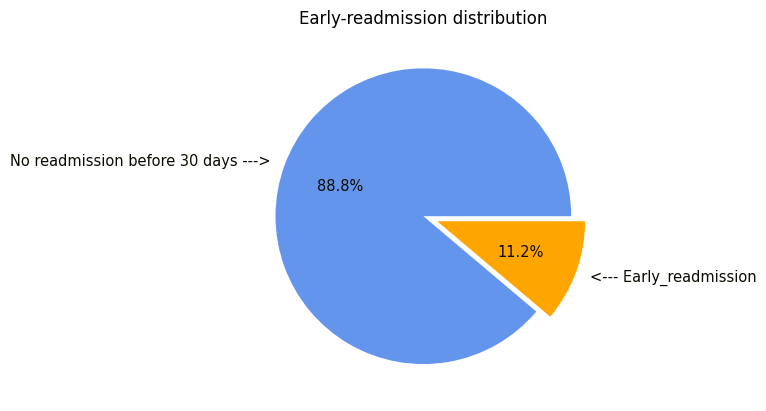

time: 288 ms (started: 2023-10-16 11:16:31 +00:00)


In [22]:
plt.title('Early-readmission distribution')
plt.pie([dist_readmission[0] + dist_readmission[1], dist_readmission[2]], labels=['No readmission before 30 days --->', '<--- Early_readmission'],
        autopct="%1.1f%%", startangle=0, textprops={'fontsize': 10.5, 'color':'#0a0a00'}, colors=['cornflowerblue', 'orange'], explode=[0, 0.1])

## Data Pre-processing

For diag_1, diag_2, diag_3 I use most common value to fill missing value.

In [23]:
df = df.withColumn("diag_1", when(df.diag_1 == "?", "577") \
      .otherwise(df.diag_1))

df = df.withColumn("diag_2", when(df.diag_2 == "?", "250.01") \
      .otherwise(df.diag_2))

df = df.withColumn("diag_3", when(df.diag_3 == "?", "250.01") \
      .otherwise(df.diag_3))

time: 185 ms (started: 2023-10-16 11:16:32 +00:00)


**diag_x** for x in 1,2,3 has too many values. I must create fewer categories to avoid curse of dimensionality.
Using domain knowledge:
1.Circulatory → 390–459, 785 → Diseases of the circulatory system
2.Respiratory → 460–519, 786 → Diseases of the respiratory system
3.Digestive → 520–579, 787 → Diseases of the digestive system
4.Diabetes → 250.xx → Diabetes mellitus
5.Injury → 800–999 → Injury and poisoning
6.Musculoskeletal → 710–739 → Diseases of the musculoskeletal system and connective tissue
7.Genitourinary → 580–629, 788 → Diseases of the genitourinary system
8.Neoplasms → 140–239 → Neoplasms
9.Pregnecy → 630–679 → Complications of pregnancy, childbirth, and the puerperium
10.Other

In [24]:
print(df.select('diag_1').distinct().count())

df = df.withColumn("diag_1", when(((df.diag_1 >= 390) & (df.diag_1 < 460)) | (df.diag_1 == 785), "circulatory")
                  .when(((df.diag_1 >= 460) & (df.diag_1 < 519)) | (df.diag_1 == 786), "respiratory")
                  .when(((df.diag_1 >= 520) & (df.diag_1 < 580)) | (df.diag_1 == 787), "digestive")
                  .when((df.diag_1 == 250), "diabetes")
                  .when((df.diag_1 >= 800) & (df.diag_1 < 1000), "injury")
                  .when((df.diag_1 >= 710) & (df.diag_1 < 740), "musculoskeletal")
                  .when(((df.diag_1 >= 580) & (df.diag_1 < 630)) | (df.diag_1 == 788), "genitourinary")
                  .when((df.diag_1 >= 140) & (df.diag_1 < 240), "neoplasms")
                  .when((df.diag_1 >= 630) & (df.diag_1 < 680), "pregnecy")
                  .otherwise("other"))

print(df.select('diag_1').distinct().count())

716
10
time: 6.93 s (started: 2023-10-16 11:16:32 +00:00)


In [25]:
print(df.select('diag_2').distinct().count())

df = df.withColumn("diag_2", when(((df.diag_2 >= 390) & (df.diag_2 < 460)) | (df.diag_2 == 785), "circulatory")
                  .when(((df.diag_2 >= 460) & (df.diag_2 < 519)) | (df.diag_2 == 786), "respiratory")
                  .when(((df.diag_2 >= 520) & (df.diag_2 < 580)) | (df.diag_2 == 787), "digestive")
                  .when((df.diag_2 == 250), "diabetes")
                  .when((df.diag_2 >= 800) & (df.diag_2 < 1000), "injury")
                  .when((df.diag_2 >= 710) & (df.diag_2 < 740), "musculoskeletal")
                  .when(((df.diag_2 >= 580) & (df.diag_2 < 630)) | (df.diag_2 == 788), "genitourinary")
                  .when((df.diag_2 >= 140) & (df.diag_2 < 240), "neoplasms")
                  .when((df.diag_2 >= 630) & (df.diag_2 < 680), "pregnecy")
                  .otherwise("other"))

print(df.select('diag_2').distinct().count())

748
10
time: 5.27 s (started: 2023-10-16 11:16:39 +00:00)


In [26]:
print(df.select('diag_3').distinct().count())

df = df.withColumn("diag_3", when(((df.diag_3 >= 390) & (df.diag_3 < 460)) | (df.diag_3 == 785), "circulatory")
                  .when(((df.diag_3 >= 460) & (df.diag_3 < 519)) | (df.diag_3 == 786), "respiratory")
                  .when(((df.diag_3 >= 520) & (df.diag_3 < 580)) | (df.diag_3 == 787), "digestive")
                  .when((df.diag_3 == 250), "diabetes")
                  .when((df.diag_3 >= 800) & (df.diag_3 < 1000), "injury")
                  .when((df.diag_3 >= 710) & (df.diag_3 < 740), "musculoskeletal")
                  .when(((df.diag_3 >= 580) & (df.diag_3 < 630)) | (df.diag_3 == 788), "genitourinary")
                  .when((df.diag_3 >= 140) & (df.diag_3 < 240), "neoplasms")
                  .when((df.diag_3 >= 630) & (df.diag_3 < 680), "pregnecy")
                  .otherwise("other"))

print(df.select('diag_3').distinct().count())

789
10
time: 7.88 s (started: 2023-10-16 11:16:44 +00:00)


For discharge_disposition the value 11, 13, 14, 19, 20, 21 indicates patient has expired, so there are no possibility that patient will readmit. I proceed by deleting the corresponding lines

In [27]:
print(df.select('discharge_disposition_id').distinct().count())

for i in [11, 13, 14, 19, 20, 21]:
  df = df.where(df.discharge_disposition_id != i)

print(df.select('discharge_disposition_id').distinct().count())

26
21
time: 6.53 s (started: 2023-10-16 11:16:52 +00:00)


Still too many values, so I proceed with merging based on the variable's description given with the dataset (example I merge not mapped/unknown/invalid as NULL which is the id = 18.
this is the mapping:
cat1 = [6, 8, 9, 13],
cat2 = [3, 4, 5, 14, 22, 23, 24],
cat10 = [12, 15, 16, 17],
cat11 = [19, 20, 21],
cat18 = [25, 26]

In [28]:
print(df.select('discharge_disposition_id').distinct().count())

df = df.withColumn("discharge_disposition_id", when((df.discharge_disposition_id == 6) | (df.discharge_disposition_id == 8) | (df.discharge_disposition_id == 9) | (df.discharge_disposition_id == 13), 1)
                                              .when((df.discharge_disposition_id == 3) | (df.discharge_disposition_id == 4) | (df.discharge_disposition_id == 5) | (df.discharge_disposition_id == 14) | (df.discharge_disposition_id == 22) | (df.discharge_disposition_id == 23) | (df.discharge_disposition_id == 24), 2)
                                              .when((df.discharge_disposition_id == 12) | (df.discharge_disposition_id == 15) | (df.discharge_disposition_id == 16) | (df.discharge_disposition_id == 17), 10)
                                              .when((df.discharge_disposition_id == 19) | (df.discharge_disposition_id == 20) | (df.discharge_disposition_id == 21), 11)
                                              .when((df.discharge_disposition_id == 25) | (df.discharge_disposition_id == 26), 18)
                                              .otherwise(df.discharge_disposition_id))

print(df.select('discharge_disposition_id').distinct().count())

21
7
time: 7.82 s (started: 2023-10-16 11:16:58 +00:00)


I have to select features wich could be important to predict the readmission rate and the presence or not of the test.
I start deleting some useless columns (for predicting readmission) and those which are not well covered.

In [29]:
df = df.drop('encounter_id', 'patient_nbr', 'payer_code', 'weight', 'medical_specialty', 'glimepiride', 'acetohexamide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'examide', 'citoglipton', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone')
# df.printSchema()
print('Features: ', len(df.columns))

Features:  30
time: 32 ms (started: 2023-10-16 11:17:06 +00:00)


Converting ordinal feature 'Age' into numerical.

In [30]:
replaceDict = {'[0-10)' : 5,
               '[10-20)' : 15,
               '[20-30)' : 25,
               '[30-40)' : 35,
               '[40-50)' : 45,
               '[50-60)' : 55,
               '[60-70)' : 65,
               '[70-80)' : 75,
               '[80-90)' : 85,
               '[90-100)' : 95}

for i in range(len(replaceDict)):
  item = replaceDict.popitem()
  key = item[0]
  value = item[1]
  df = df.withColumn("age", when(df.age == key, value) \
        .otherwise(df.age))

df = df.withColumn("age", df.age.cast(IntegerType()))

time: 272 ms (started: 2023-10-16 11:17:06 +00:00)


Check and drop duplicates ---> same shape as before, so no duplicates.

In [31]:
print(df.distinct().count())

99340
time: 22.1 s (started: 2023-10-16 11:17:07 +00:00)


Admission Type ID :

reducing number of categories
cat1 = [2, 7],
cat5 = [6, 8]

In [32]:
print(df.select('admission_type_id').distinct().count())

df = df.withColumn("admission_type_id", when((df.admission_type_id == 2) | (df.admission_type_id == 7), 1)
                                              .when((df.admission_type_id == 6) | (df.admission_type_id == 8), 5)
                                              .otherwise(df.admission_type_id))

print(df.select('admission_type_id').distinct().count())

8
4
time: 7.84 s (started: 2023-10-16 11:17:29 +00:00)


Admission Source ID :

reducing number of categories
cat1 = [2, 3],
cat4 = [5, 6, 10, 22, 25],
cat9 = [15, 17, 20, 21],
cat11 = [13, 17]

In [33]:
print(df.select('admission_source_id').distinct().count())

df = df.withColumn("admission_source_id", when((df.admission_source_id == 2) | (df.admission_source_id == 3), 1)
                                              .when((df.admission_source_id == 5) | (df.admission_source_id == 6) | (df.admission_source_id == 10) | (df.admission_source_id == 22) | (df.admission_source_id == 25), 4)
                                              .when((df.admission_source_id == 15) | (df.admission_source_id == 17) | (df.admission_source_id == 20) | (df.admission_source_id == 21), 9)
                                              .when((df.admission_source_id == 13) | (df.admission_source_id == 14), 11)
                                              .otherwise(df.admission_source_id))

print(df.select('admission_source_id').distinct().count())

17
6
time: 6.55 s (started: 2023-10-16 11:17:37 +00:00)


**Creating new features:**

If the frequency of person’s visit to the hospital is high then the person could be less healthier and tends to readmit quickly. Creating a new variable health_index. Higher the health_index lesser the chance that person will readmit (indirectly proportional).

**Health_index** = ( 1 / (number_emergency + number_inpatient + number_outpatient) )

In [34]:
df = df.withColumn("health_index", expr("1 / (number_emergency + number_inpatient + number_outpatient)"))
# handling when all 3 variables in the denominator are 0 ---> (solution) giving a number > 1
df = df.withColumn("health_index", when(df.health_index.isNull(), 2) \
      .otherwise(df.health_index))

time: 513 ms (started: 2023-10-16 11:17:43 +00:00)


Severity of disease is high if patient is spending lots of time in hospital and going through number of complicated test so. To get probabilistic interpretation lets divide it by total values.

**severity_of_disease** = (time_in_hospital + num_procedures + num_medications + num_lab_procedures + number_of_diagnoses) / total

In [35]:
df = df.withColumn("sum", expr("time_in_hospital + num_procedures + num_medications + num_lab_procedures + number_diagnoses"))
total_value = df.select(sum(df.sum)).first()["sum(sum)"]
df = df.withColumn("total", lit(total_value)).withColumn("sum", expr("sum / total")).withColumnRenamed("sum", "severity_of_disease").drop("total")

time: 1.52 s (started: 2023-10-16 11:17:44 +00:00)


In [36]:
df.show(5)

+---------------+------+---+-----------------+------------------------+-------------------+----------------+------------------+--------------+---------------+-----------------+----------------+----------------+---------+---------+-----------+----------------+-------------+---------+---------+-----------+-----------+--------------+---------+---------+----------+-------+------+-----------+----------+------------------+--------------------+
|           race|gender|age|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|   diag_1|   diag_2|     diag_3|number_diagnoses|max_glu_serum|A1Cresult|metformin|repaglinide|nateglinide|chlorpropamide|glipizide|glyburide|tolazamide|insulin|change|diabetesMed|readmitted|      health_index| severity_of_disease|
+---------------+------+---+-----------------+------------------------+-------------------+----------------+--------

Now we need to transform the data into numbers so that we can work on them with ML models.

In [37]:
# looking for categorical and numeric columns
numeric_columns = list()
categorical_columns = list()

for col in df.columns:
    if df.select(col).dtypes[0][1] != "string":
        numeric_columns.append(col)
    else:
        categorical_columns.append(col)

print("Numeric columns: ", numeric_columns)
print("\n")
print("Categorical columns: ", categorical_columns)

Numeric columns:  ['age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'health_index', 'severity_of_disease']


Categorical columns:  ['race', 'gender', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glipizide', 'glyburide', 'tolazamide', 'insulin', 'change', 'diabetesMed', 'readmitted']
time: 491 ms (started: 2023-10-16 11:17:52 +00:00)


A lot of features are strings, so I define a function wich maps string into numbers

In [38]:
def categorical_to_numerical(col_name, col_out_name, df):
    stringIndexer = StringIndexer(inputCol=col_name, outputCol=col_out_name)
    df_new = stringIndexer.fit(df).transform(df)
    return df_new

time: 708 µs (started: 2023-10-16 11:17:52 +00:00)


In [39]:
for col in categorical_columns:
    new_name = col + "_indexed"
    df = categorical_to_numerical(col, new_name, df)

time: 33 s (started: 2023-10-16 11:17:52 +00:00)


Dropping old columns with strings

In [40]:
for col in categorical_columns:
  df = df.drop(col)

time: 282 ms (started: 2023-10-16 11:18:25 +00:00)


In [41]:
# New schema of numeric features
df.printSchema()
print('Features: ', len(df.columns))

root
 |-- age: integer (nullable = true)
 |-- admission_type_id: long (nullable = true)
 |-- discharge_disposition_id: long (nullable = true)
 |-- admission_source_id: long (nullable = true)
 |-- time_in_hospital: long (nullable = true)
 |-- num_lab_procedures: long (nullable = true)
 |-- num_procedures: long (nullable = true)
 |-- num_medications: long (nullable = true)
 |-- number_outpatient: long (nullable = true)
 |-- number_emergency: long (nullable = true)
 |-- number_inpatient: long (nullable = true)
 |-- number_diagnoses: long (nullable = true)
 |-- health_index: double (nullable = true)
 |-- severity_of_disease: double (nullable = true)
 |-- race_indexed: double (nullable = false)
 |-- gender_indexed: double (nullable = false)
 |-- diag_1_indexed: double (nullable = false)
 |-- diag_2_indexed: double (nullable = false)
 |-- diag_3_indexed: double (nullable = false)
 |-- max_glu_serum_indexed: double (nullable = false)
 |-- A1Cresult_indexed: double (nullable = false)
 |-- metf

Visualize the correlation matrix

In [42]:
assembler = VectorAssembler(inputCols=df.columns, outputCol='corr_features')
df_vector = assembler.transform(df).select('corr_features')

matrix = Correlation.corr(df_vector, 'corr_features').collect()[0][0]

corr_matrix = matrix.toArray().tolist()
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns=df.columns, index=df.columns)
corr_matrix_df .style.background_gradient(cmap='coolwarm').set_precision(2)

<ipython-input-42-df85628b49cb>:8: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_matrix_df .style.background_gradient(cmap='coolwarm').set_precision(2)


,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,health_index,severity_of_disease,race_indexed,gender_indexed,diag_1_indexed,diag_2_indexed,diag_3_indexed,max_glu_serum_indexed,A1Cresult_indexed,metformin_indexed,repaglinide_indexed,nateglinide_indexed,chlorpropamide_indexed,glipizide_indexed,glyburide_indexed,tolazamide_indexed,insulin_indexed,change_indexed,diabetesMed_indexed,readmitted_indexed
age,1.00,-0.00,0.01,0.04,0.11,0.02,-0.03,0.04,0.02,-0.09,-0.04,0.24,-0.01,0.06,-0.12,-0.05,-0.11,-0.06,-0.06,0.02,-0.05,-0.05,0.05,0.02,0.01,0.06,0.08,0.01,-0.10,-0.03,0.02,0.04
admission_type_id,-0.00,1.00,0.08,-0.19,-0.02,-0.16,0.12,0.10,0.04,-0.02,-0.04,-0.10,-0.01,-0.09,-0.04,0.01,0.09,0.03,0.02,0.37,-0.06,0.02,-0.02,-0.01,0.01,0.01,0.00,0.01,-0.00,0.01,0.00,-0.01
discharge_disposition_id,0.01,0.08,1.00,-0.00,0.06,0.00,0.01,0.00,-0.04,-0.03,-0.00,-0.05,0.04,0.01,0.00,-0.00,-0.02,-0.02,-0.01,0.03,-0.00,-0.00,-0.01,-0.02,0.03,-0.02,0.07,0.02,-0.09,-0.06,0.06,-0.00
admission_source_id,0.04,-0.19,-0.00,1.00,0.00,0.16,-0.20,-0.09,0.01,0.07,0.06,0.12,-0.07,0.09,0.01,-0.01,-0.15,-0.05,-0.03,0.22,0.04,-0.03,0.01,-0.01,-0.01,0.01,0.00,0.00,0.04,0.01,-0.00,0.06
time_in_hospital,0.11,-0.02,0.06,0.00,1.00,0.32,0.19,0.46,-0.01,-0.01,0.07,0.22,-0.05,0.54,-0.01,-0.03,0.00,0.05,0.06,0.03,0.06,0.01,0.04,0.01,0.00,0.04,0.04,-0.00,0.13,0.11,-0.06,0.06
num_lab_procedures,0.02,-0.16,0.00,0.16,0.32,1.00,0.05,0.27,-0.01,-0.00,0.04,0.15,-0.01,0.91,0.01,-0.00,-0.07,0.00,0.03,-0.12,0.23,-0.03,0.02,-0.01,-0.00,0.03,0.01,-0.00,0.11,0.07,-0.03,0.05
num_procedures,-0.03,0.12,0.01,-0.20,0.19,0.05,1.00,0.38,-0.03,-0.04,-0.07,0.07,0.09,0.26,-0.02,0.06,-0.02,-0.01,0.02,-0.07,-0.01,-0.04,0.00,-0.00,0.01,0.01,0.01,0.00,0.01,0.00,0.01,-0.04
num_medications,0.04,0.10,0.00,-0.09,0.46,0.27,0.38,1.00,0.05,0.01,0.07,0.26,-0.08,0.62,-0.06,-0.02,0.02,0.01,0.02,-0.00,0.03,0.08,0.02,0.02,0.00,0.06,0.04,-0.00,0.24,0.25,-0.18,0.06
number_outpatient,0.02,0.04,-0.04,0.01,-0.01,-0.01,-0.03,0.05,1.00,0.09,0.11,0.09,-0.43,0.01,-0.04,-0.01,0.02,0.01,0.01,0.05,-0.02,-0.01,0.00,0.00,-0.01,0.01,-0.00,-0.01,0.03,0.03,-0.02,0.07
number_emergency,-0.09,-0.02,-0.03,0.07,-0.01,-0.00,-0.04,0.01,0.09,1.00,0.27,0.06,-0.31,0.00,0.01,-0.02,0.01,0.01,0.01,0.04,-0.01,-0.01,0.01,0.00,-0.00,-0.01,-0.03,-0.00,0.07,0.04,-0.03,0.10


time: 51.3 s (started: 2023-10-16 11:18:26 +00:00)


Visualizing how numeric columns are made

In [43]:
df.show(10)
print(len(df.columns))

+---+-----------------+------------------------+-------------------+----------------+------------------+--------------+---------------+-----------------+----------------+----------------+----------------+------------------+--------------------+------------+--------------+--------------+--------------+--------------+---------------------+-----------------+-----------------+-------------------+-------------------+----------------------+-----------------+-----------------+------------------+---------------+--------------+-------------------+------------------+
|age|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|number_diagnoses|      health_index| severity_of_disease|race_indexed|gender_indexed|diag_1_indexed|diag_2_indexed|diag_3_indexed|max_glu_serum_indexed|A1Cresult_indexed|metformin_indexed|repaglinide_indexed|nateglinide_indexed|chlorpropamide_indexe

Normalising and aggregating inputs to reach better performances

Scaling to a range or z-score are good when I know upper and lower bouds with few outliers and data are uniformly distribuited; selecting this kind of features.

In [44]:
def normalisation_step(df, input_cols, column_name):
  vec_assembler = VectorAssembler(inputCols=input_cols, outputCol='vect_features_' + column_name)
  df = vec_assembler.transform(df)

  scaler = StandardScaler(inputCol='vect_features_' + column_name, outputCol='norm_features_' + column_name, withStd=True, withMean=True)
  scalerModel = scaler.fit(df)

  df_new = scalerModel.transform(df)
  df_new = df_new.drop('vect_features_' + column_name)

  return df_new

time: 969 µs (started: 2023-10-16 11:19:24 +00:00)


Data after normalisation

In [45]:
df_pred_readmission = normalisation_step(df, df.drop('readmitted_indexed').columns, 'toPredReadmission')
df_pred_A1Cresult = normalisation_step(df, df.drop('A1Cresult_indexed').columns, 'toPredA1Cresult')

time: 52.9 s (started: 2023-10-16 11:19:24 +00:00)


In [46]:
# Building the dataset with only rows with A1Cresult's test done (need it for the project work in the last section)
df_pred_readmission_withA1Cresults = df_pred_readmission.filter(df_pred_readmission.A1Cresult_indexed != 0.0)
df_pred_readmission_withA1Cresults = df_pred_readmission_withA1Cresults.select(["norm_features_toPredReadmission", "readmitted_indexed"])
df_pred_readmission_withA1Cresults.show(5)

+-------------------------------+------------------+
|norm_features_toPredReadmission|readmitted_indexed|
+-------------------------------+------------------+
|           [1.20761980818831...|               0.0|
|           [0.58047087041334...|               1.0|
|           [-0.6738270051366...|               0.0|
|           [-0.0466780673616...|               0.0|
|           [1.20761980818831...|               1.0|
+-------------------------------+------------------+
only showing top 5 rows

time: 7.37 s (started: 2023-10-16 11:20:17 +00:00)


In [47]:
# Printing first row of norm_features_toPredReadmission which will be used as indipendent variable in the prediction models
print(df_pred_readmission.select('norm_features_toPredReadmission').collect()[0])
print(len(df_pred_readmission.columns))
print('\n')
print(df_pred_A1Cresult.select('norm_features_toPredA1Cresult').collect()[0])
print(len(df_pred_A1Cresult.columns))

Row(norm_features_toPredReadmission=DenseVector([-3.8096, 2.4163, 4.2535, -1.4272, -1.1384, -0.0972, -0.7836, -1.8504, -0.2919, -0.2116, -0.5006, -3.2981, 0.8562, -1.1002, -0.4584, -0.9265, 0.6675, 0.0715, 0.1422, -0.211, -0.4033, -0.4641, -0.117, -0.0803, -0.028, -0.3489, -0.3136, -0.0196, -0.8684, -0.9309, 1.8415]))
33


Row(norm_features_toPredA1Cresult=DenseVector([-3.8096, 2.4163, 4.2535, -1.4272, -1.1384, -0.0972, -0.7836, -1.8504, -0.2919, -0.2116, -0.5006, -3.2981, 0.8562, -1.1002, -0.4584, -0.9265, 0.6675, 0.0715, 0.1422, -0.211, -0.4641, -0.117, -0.0803, -0.028, -0.3489, -0.3136, -0.0196, -0.8684, -0.9309, 1.8415, -0.853]))
33
time: 43.7 s (started: 2023-10-16 11:20:24 +00:00)


In [48]:
df_pred_readmission = df_pred_readmission.select(["norm_features_toPredReadmission", "readmitted_indexed"])
df_pred_A1Cresult = df_pred_A1Cresult.select(["norm_features_toPredA1Cresult", "A1Cresult_indexed"])

time: 73.3 ms (started: 2023-10-16 11:21:08 +00:00)


Visualize final df, ready to use in training models

In [49]:
df_pred_readmission.show(5)
df_pred_A1Cresult.show(5)

+-------------------------------+------------------+
|norm_features_toPredReadmission|readmitted_indexed|
+-------------------------------+------------------+
|           [-3.8095716940114...|               0.0|
|           [-3.1824227562364...|               1.0|
|           [-2.5552738184615...|               0.0|
|           [-1.9281248806865...|               0.0|
|           [-1.3009759429115...|               0.0|
+-------------------------------+------------------+
only showing top 5 rows

+-----------------------------+-----------------+
|norm_features_toPredA1Cresult|A1Cresult_indexed|
+-----------------------------+-----------------+
|         [-3.8095716940114...|              0.0|
|         [-3.1824227562364...|              0.0|
|         [-2.5552738184615...|              0.0|
|         [-1.9281248806865...|              0.0|
|         [-1.3009759429115...|              0.0|
+-----------------------------+-----------------+
only showing top 5 rows

time: 8.77 s (started: 

## Splitting Dataset in Taining and Test

In [50]:
(df_train_readmission, df_test_readmission) = df_pred_readmission.randomSplit([0.8, 0.2], seed=seed)
print('Number of instances in the training set:', df_train_readmission.count())
print('Number of instances in the test set:', df_test_readmission.count())

Number of instances in the training set: 79553
Number of instances in the test set: 19790
time: 25.5 s (started: 2023-10-16 11:21:17 +00:00)


In [51]:
(df_train_A1C, df_test_A1C) = df_pred_A1Cresult.randomSplit([0.8, 0.2], seed=seed)
print('Number of instances in the training set:', df_train_A1C.count())
print('Number of instances in the test set:', df_test_A1C.count())

Number of instances in the training set: 79553
Number of instances in the test set: 19790
time: 23.5 s (started: 2023-10-16 11:21:42 +00:00)


## Predicting Readmission

In [52]:
df_train_readmission.show(3)

+-------------------------------+------------------+
|norm_features_toPredReadmission|readmitted_indexed|
+-------------------------------+------------------+
|           [-3.8095716940114...|               0.0|
|           [-3.8095716940114...|               0.0|
|           [-3.8095716940114...|               0.0|
+-------------------------------+------------------+
only showing top 3 rows

time: 6.73 s (started: 2023-10-16 11:22:06 +00:00)


### Starting predicting all 3 classes separated: 'NO', '>30', '<30'.

#### Decision Tree classifier

Train decision tree

In [53]:
dt_classifier = DecisionTreeClassifier(labelCol="readmitted_indexed", featuresCol="norm_features_toPredReadmission")
model1 = dt_classifier.fit(df_train_readmission)

time: 38.1 s (started: 2023-10-16 11:22:12 +00:00)


Test decision tree

In [54]:
predictions = model1.transform(df_test_readmission)
evaluator = MulticlassClassificationEvaluator(labelCol="readmitted_indexed", predictionCol="prediction", metricName="f1")
accuracy = evaluator.evaluate(predictions)

print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.52
time: 11.8 s (started: 2023-10-16 11:22:50 +00:00)


In [55]:
print(model1.featureImportances)

(31,[2,10,11,12,13,18,28],[0.01706837432802734,0.20156281980986182,0.028560655020832236,0.7302035498788839,0.014661014578903866,0.003529090487912242,0.0044144958955785706])
time: 60.7 ms (started: 2023-10-16 11:23:02 +00:00)


#### Random Forest

In [56]:
rf = RandomForestClassifier(labelCol="readmitted_indexed", featuresCol="norm_features_toPredReadmission")
model2 = rf.fit(df_train_readmission)

time: 40.5 s (started: 2023-10-16 11:23:02 +00:00)


In [57]:
predictions = model2.transform(df_test_readmission)
evaluator = MulticlassClassificationEvaluator(labelCol="readmitted_indexed", predictionCol="prediction", metricName="f1")
accuracy = evaluator.evaluate(predictions)

print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.52
time: 11 s (started: 2023-10-16 11:23:43 +00:00)


### Predicting general readmission, before or after 30 days ---> 2 classes: 'NO' and 'general_readmission'.

Unification of <30 and >30.

In [58]:
df_train_readmission.show(10)
print(df_train_readmission.select('readmitted_indexed').distinct())

+-------------------------------+------------------+
|norm_features_toPredReadmission|readmitted_indexed|
+-------------------------------+------------------+
|           [-3.8095716940114...|               0.0|
|           [-3.8095716940114...|               0.0|
|           [-3.8095716940114...|               0.0|
|           [-3.8095716940114...|               0.0|
|           [-3.8095716940114...|               0.0|
|           [-3.8095716940114...|               0.0|
|           [-3.8095716940114...|               0.0|
|           [-3.8095716940114...|               0.0|
|           [-3.8095716940114...|               0.0|
|           [-3.8095716940114...|               0.0|
+-------------------------------+------------------+
only showing top 10 rows

+------------------+
|readmitted_indexed|
+------------------+
|               0.0|
|               1.0|
|               2.0|
+------------------+

time: 21.8 s (started: 2023-10-16 11:23:54 +00:00)


Modified dataset

In [59]:
df_train_readmission_binary = df_train_readmission.withColumn("readmitted_indexed", when(df_train_readmission.readmitted_indexed == 2.0, 1.0) \
      .when(df_train_readmission.readmitted_indexed == 1.0, 1.0) \
      .otherwise(df_train_readmission.readmitted_indexed))
df_train_readmission_binary.select("readmitted_indexed").distinct()

readmitted_indexed
0.0
1.0


time: 25.7 s (started: 2023-10-16 11:24:16 +00:00)


In [60]:
df_test_readmission_binary = df_test_readmission.withColumn("readmitted_indexed", when(df_test_readmission.readmitted_indexed == 2.0, 1.0) \
      .when(df_test_readmission.readmitted_indexed == 1.0, 1.0) \
      .otherwise(df_test_readmission.readmitted_indexed))
df_test_readmission_binary.select("readmitted_indexed").distinct()

readmitted_indexed
0.0
1.0


time: 25.9 s (started: 2023-10-16 11:24:41 +00:00)


In [61]:
df_train_readmission_binary.groupBy("readmitted_indexed").count().show()
df_test_readmission_binary.groupBy("readmitted_indexed").count().show()

+------------------+-----+
|readmitted_indexed|count|
+------------------+-----+
|               0.0|42023|
|               1.0|37530|
+------------------+-----+

+------------------+-----+
|readmitted_indexed|count|
+------------------+-----+
|               0.0|10504|
|               1.0| 9286|
+------------------+-----+

time: 39.3 s (started: 2023-10-16 11:25:07 +00:00)


In [62]:
dt_classifier = DecisionTreeClassifier(labelCol="readmitted_indexed", featuresCol="norm_features_toPredReadmission")
model3 = dt_classifier.fit(df_train_readmission_binary)

predictions = model3.transform(df_test_readmission_binary)
evaluator = MulticlassClassificationEvaluator(labelCol="readmitted_indexed", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.62
time: 57.5 s (started: 2023-10-16 11:25:47 +00:00)


###  Predicting early readmission ---> unification for NO and >30.

In [63]:
df_train_readmission_binary2 = df_train_readmission.withColumn("readmitted_indexed", when(df_train_readmission.readmitted_indexed == 2.0, 1.0) \
      .when(df_train_readmission.readmitted_indexed == 1.0, 0.0) \
      .otherwise(df_train_readmission.readmitted_indexed))
df_train_readmission_binary2.select("readmitted_indexed").distinct()

readmitted_indexed
0.0
1.0


time: 24.2 s (started: 2023-10-16 11:26:44 +00:00)


In [64]:
df_test_readmission_binary2 = df_test_readmission.withColumn("readmitted_indexed", when(df_test_readmission.readmitted_indexed == 2.0, 1.0) \
      .when(df_test_readmission.readmitted_indexed == 1.0, 0.0) \
      .otherwise(df_test_readmission.readmitted_indexed))
df_test_readmission_binary2.select("readmitted_indexed").distinct()

readmitted_indexed
0.0
1.0


time: 26 s (started: 2023-10-16 11:27:08 +00:00)


In [65]:
df_train_readmission_binary2.groupBy("readmitted_indexed").count().show()
df_test_readmission_binary2.groupBy("readmitted_indexed").count().show()

+------------------+-----+
|readmitted_indexed|count|
+------------------+-----+
|               0.0|70500|
|               1.0| 9053|
+------------------+-----+

+------------------+-----+
|readmitted_indexed|count|
+------------------+-----+
|               0.0|17529|
|               1.0| 2261|
+------------------+-----+

time: 26.8 s (started: 2023-10-16 11:27:34 +00:00)


In [66]:
dt_classifier2 = DecisionTreeClassifier(labelCol="readmitted_indexed", featuresCol="norm_features_toPredReadmission")
model4 = dt_classifier2.fit(df_train_readmission_binary2)

predictions = model4.transform(df_test_readmission_binary2)
evaluator = MulticlassClassificationEvaluator(labelCol="readmitted_indexed", predictionCol="prediction", metricName="f1")
accuracy = evaluator.evaluate(predictions)

print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.83
time: 57 s (started: 2023-10-16 11:28:01 +00:00)


In [67]:
predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|19749|
|       1.0|   41|
+----------+-----+

time: 14.6 s (started: 2023-10-16 11:28:58 +00:00)


Those models are not enough precise, trying deep models.

#### Deep Learning models: MLPC

Starting with multilayerPerceptron of MLlib.

In [68]:
df_mlpc_train = df_train_readmission_binary2.withColumnRenamed("norm_features_toPredReadmission","features").withColumnRenamed("readmitted_indexed", "label")
df_mlpc_test = df_test_readmission_binary2.withColumnRenamed("norm_features_toPredReadmission","features").withColumnRenamed("readmitted_indexed", "label")

layers = [31, 60, 30, 15, 8, 2]
mlpc = MultilayerPerceptronClassifier(layers = layers, blockSize = 64, seed = seed, solver='gd')

nn_model = mlpc.fit(df_mlpc_train)
prediction_result = nn_model.transform(df_mlpc_test)
predictionAndLabels = prediction_result.select("prediction", "label")
predictionAndLabels.show()

evaluator = MulticlassClassificationEvaluator(metricName="f1")
print("Test set f1 = " + str(evaluator.evaluate(predictionAndLabels)))

+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
+----------+-----+
only showing top 20 rows

Test set f1 = 0.8320865185630827
time: 4min 8s (started: 2023-10-16 11:29:13 +00:00)


In [69]:
prediction_result.groupBy('label').count().show()
prediction_result.groupBy('prediction').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|17529|
|  1.0| 2261|
+-----+-----+

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|19790|
+----------+-----+

time: 26.6 s (started: 2023-10-16 11:33:21 +00:00)


It's a very limited network just to try the implementation, it is unable to predict early readmission for such a complex task.

#### Custom network with keras and horovod framework

The horovod.spark package provides a convenient wrapper around Horovod that makes running distributed training jobs in Spark clusters easy.
More details can be found here: https://horovod.readthedocs.io/en/stable/

Trying a 1D convolutional NN as suggested in this paper https://link.springer.com/article/10.1007/s00521-021-06431-7:

In [70]:
model = Sequential(
    [
      Conv1D(128, 3, activation='relu', input_shape=(31,1)),
      Conv1D(64, 3, activation='relu'),
      MaxPooling1D(pool_size=2, padding="valid"),
      Conv1D(32, 3, activation='relu'),
      Conv1D(16, 3, activation='relu'),
      Flatten(),
      Dense(10, activation='relu'),
      Dense(1, activation='sigmoid'),
    ]
)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 29, 128)           512       
                                                                 
 conv1d_1 (Conv1D)           (None, 27, 64)            24640     
                                                                 
 max_pooling1d (MaxPooling1  (None, 13, 64)            0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 11, 32)            6176      
                                                                 
 conv1d_3 (Conv1D)           (None, 9, 16)             1552      
                                                                 
 flatten (Flatten)           (None, 144)               0         
                                                        

In [71]:
work_dir = "/dbfs/horovod_spark_estimator/"
store = DBFSLocalStore(work_dir)

hvd_estimator = hvd.KerasEstimator(
    model=model,
    store=store,
    optimizer=keras.optimizers.SGD(lr=0.01),
    loss='binary_crossentropy',
    feature_cols=['norm_features_toPredReadmission'],
    label_cols=['readmitted_indexed'],
    batch_size=128,
    epochs=30,
    )

hvd_model = hvd_estimator.fit(df_train_readmission_binary2) \
    .setOutputCols(['predict'])

num_partitions=20
writing dataframes
train_data_path=file:///dbfs/horovod_spark_estimator/intermediate_train_data.0
val_data_path=file:///dbfs/horovod_spark_estimator/intermediate_val_data.0
train_partitions=20
train_rows=79553


/usr/local/lib/python3.10/dist-packages/horovod/spark/common/util.py:495: FutureWarning: 'ParquetDataset.schema' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.schema' attribute instead (which will return an Arrow schema instead of a Parquet schema).
  train_data_schema = train_data.schema.to_arrow_schema()
/usr/local/lib/python3.10/dist-packages/horovod/spark/common/util.py:405: FutureWarning: 'ParquetDataset.pieces' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.fragments' attribute instead.
  for piece in dataset.pieces:
/usr/local/lib/python3.10/dist-packages/horovod/spark/common/util.py:513: FutureWarning: The 'field_by_name' method is deprecated, use 'field' instead
  metadata, avg_row_size = make_metadata_dictionary(train

[1,0]<stdout>:Pinning current process to the GPU.
[1,0]<stdout>:Shared lib path is pointing to: <CDLL '/usr/local/lib/python3.10/dist-packages/horovod/tensorflow/mpi_lib.cpython-310-x86_64-linux-gnu.so', handle 5b07585d92c0 at 0x7de61552c070>
[1,0]<stdout>:Training parameters: Epochs: 30, Scaled lr: 0.019999999552965164, Shuffle: True, random_seed: None
[1,0]<stdout>:Train rows: 79553, Train batch size: 128, Train_steps_per_epoch: 311
[1,0]<stdout>:Val rows: 0, Val batch size: 128, Val_steps_per_epoch: None
[1,0]<stdout>:Checkpoint file: file:///dbfs/horovod_spark_estimator/runs/keras_1697456053, Logs dir: file:///dbfs/horovod_spark_estimator/runs/keras_1697456053/logs
[1,0]<stdout>:
[1,0]<stdout>:data_module: <class 'horovod.spark.keras.datamodule.PetastormDataModule'>


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,0]<stderr>:  self._filesystem = pyarrow.localfs
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/etl/dataset_metadata.py:402: FutureWarning: Specifying the 'metadata_nthreads' argument is deprecated as of pyarrow 8.0.0, and the argument will be removed in a future version
[1,0]<stderr>:  dataset = pq.ParquetDataset(path_or_paths, filesystem=fs, validate_schema=False, metadata_nthreads=10)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/etl/dataset_metadata.py:362: FutureWarning: 'ParquetDataset.common_metadata' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version.
[1,0]<stderr>:  if not dataset.common_metadata:
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/reader.py:420: FutureWarning: Specifying the 'metadata_nthreads' ar

[1,0]<stdout>:Epoch 1/30


[1,0]<stderr>:WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0988s vs `on_train_batch_end` time: 0.1050s). Check your callbacks.


[1,1]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,1]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)


311/311 [==============================] - 47s 127ms/step - loss: 0.4454
[1,0]<stdout>:Epoch 2/30
311/311 [==============================] - 27s 88ms/step - loss: 0.3545
[1,0]<stdout>:Epoch 3/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:291: FutureWarning: 'ParquetDataset.partitions' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.partitioning' attribute instead.
[1,0]<stderr>:  table = piece.read(columns=column_names - partition_names, partitions=self._dataset.partitions)


311/311 [==============================] - 30s 98ms/step - loss: 0.3514
[1,0]<stdout>:Epoch 4/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

311/311 [==============================] - 35s 114ms/step - loss: 0.3501
[1,0]<stdout>:Epoch 5/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

311/311 [==============================] - 33s 105ms/step - loss: 0.3473
[1,0]<stdout>:Epoch 6/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

311/311 [==============================] - 31s 100ms/step - loss: 0.3438
[1,0]<stdout>:Epoch 7/30
311/311 [==============================] - 27s 87ms/step - loss: 0.3415
[1,0]<stdout>:Epoch 8/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

311/311 [==============================] - 30s 97ms/step - loss: 0.3413
[1,0]<stdout>:Epoch 9/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

311/311 [==============================] - 31s 99ms/step - loss: 0.3421
[1,0]<stdout>:Epoch 10/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

311/311 [==============================] - 30s 96ms/step - loss: 0.3395
[1,0]<stdout>:Epoch 11/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

311/311 [==============================] - 29s 93ms/step - loss: 0.3427
[1,0]<stdout>:Epoch 12/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

311/311 [==============================] - 31s 99ms/step - loss: 0.3395
[1,0]<stdout>:Epoch 13/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

311/311 [==============================] - 31s 100ms/step - loss: 0.3410
[1,0]<stdout>:Epoch 14/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

311/311 [==============================] - 29s 92ms/step - loss: 0.3399
[1,0]<stdout>:Epoch 15/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

311/311 [==============================] - 29s 95ms/step - loss: 0.3417
[1,0]<stdout>:Epoch 16/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

311/311 [==============================] - 30s 98ms/step - loss: 0.3394
[1,0]<stdout>:Epoch 17/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

311/311 [==============================] - 30s 98ms/step - loss: 0.3412
[1,0]<stdout>:Epoch 18/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

311/311 [==============================] - 29s 93ms/step - loss: 0.3404
[1,0]<stdout>:Epoch 19/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

311/311 [==============================] - 30s 96ms/step - loss: 0.3403
[1,0]<stdout>:Epoch 20/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

311/311 [==============================] - 31s 99ms/step - loss: 0.3395
[1,0]<stdout>:Epoch 21/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

311/311 [==============================] - 31s 98ms/step - loss: 0.3403
[1,0]<stdout>:Epoch 22/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

311/311 [==============================] - 27s 87ms/step - loss: 0.3392
[1,0]<stdout>:Epoch 23/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

311/311 [==============================] - 30s 96ms/step - loss: 0.3406
[1,0]<stdout>:Epoch 24/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

311/311 [==============================] - 31s 100ms/step - loss: 0.3379
[1,0]<stdout>:Epoch 25/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

311/311 [==============================] - 30s 97ms/step - loss: 0.3406
[1,0]<stdout>:Epoch 26/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

311/311 [==============================] - 27s 87ms/step - loss: 0.3413
[1,0]<stdout>:Epoch 27/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

311/311 [==============================] - 30s 96ms/step - loss: 0.3389
[1,0]<stdout>:Epoch 28/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

311/311 [==============================] - 30s 96ms/step - loss: 0.3412
[1,0]<stdout>:Epoch 29/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

311/311 [==============================] - 27s 88ms/step - loss: 0.3397
[1,0]<stdout>:Epoch 30/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

311/311 [==============================] - 31s 98ms/step - loss: 0.3391


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/horovod/spark/keras/util.py:223: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
[1,0]<stderr>:  save_model_fn(model, f)


time: 16min 12s (started: 2023-10-16 11:33:48 +00:00)


In [76]:
predict_df = hvd_model.transform(df_test_readmission_binary2)
predict_df = predict_df.withColumn("predict", when(predict_df.predict < 0.3, 0.0).otherwise(1.0))

evaluator = MulticlassClassificationEvaluator(
  predictionCol='predict', labelCol='readmitted_indexed', metricName='f1')
print('Test F1:', evaluator.evaluate(predict_df))

Test F1: 0.8404701327649304
time: 2min 25s (started: 2023-10-16 13:11:07 +00:00)


In [81]:
# How many ones are correct? Let's compare labels and predictions in a new column
print("Ones predicted:")
predict_df.groupBy('predict').count().show()

print("\nOnes Correct:")
predict_df = predict_df.withColumn('correct 1', when((predict_df.predict == 1.0) & (predict_df.readmitted_indexed == 1.0), 1.0).otherwise(0.0))
predict_df.groupBy('correct 1').count().show()

Ones predicted:
+-------+-----+
|predict|count|
+-------+-----+
|    0.0|19393|
|    1.0|  397|
+-------+-----+


Ones Correct:
+---------+-----+
|correct 1|count|
+---------+-----+
|      0.0|19652|
|      1.0|  138|
+---------+-----+

time: 4min 17s (started: 2023-10-16 13:20:30 +00:00)


So now I can play with the threshold to find a trade-off between 0-error and 1-error

Trying PCA to improve performance

In [82]:
pca = PCA(
    k = 15,
    inputCol = 'norm_features_toPredReadmission',
    outputCol = 'pcaFeatures'
).fit(df_train_readmission_binary2)

df_train_pca = pca.transform(df_train_readmission_binary2)
df_test_pca = pca.transform(df_test_readmission_binary2)

print('Explained Variance Ratio', pca.explainedVariance.toArray()) # from this I have seen how many components to select

Explained Variance Ratio [0.10222815 0.06890062 0.06649803 0.05277852 0.04723434 0.04124038
 0.03967399 0.03780522 0.03510643 0.03443922 0.03424951 0.03284408
 0.03237846 0.03209193 0.0311499 ]
time: 49.3 s (started: 2023-10-16 13:25:01 +00:00)


Testing the same model to see if there are improvements.

In [83]:
model = Sequential(
    [
      Conv1D(128, 3, activation='relu', input_shape=(15,1)),
      Conv1D(64, 3, activation='relu'),
      MaxPooling1D(pool_size=2, padding="valid"),
      Conv1D(32, 3, activation='relu'),
      Conv1D(16, 3, activation='relu'),
      Flatten(),
      Dense(10, activation='relu'),
      Dense(1, activation='sigmoid'),
    ]
)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 13, 128)           512       
                                                                 
 conv1d_5 (Conv1D)           (None, 11, 64)            24640     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 5, 64)             0         
 g1D)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 3, 32)             6176      
                                                                 
 conv1d_7 (Conv1D)           (None, 1, 16)             1552      
                                                                 
 flatten_1 (Flatten)         (None, 16)                0         
                                                      

In [84]:
work_dir = "/dbfs/horovod_spark_estimator/"
store = DBFSLocalStore(work_dir)

hvd_estimator = hvd.KerasEstimator(
    model=model,
    store=store,
    optimizer=keras.optimizers.SGD(lr=0.01),
    loss='binary_crossentropy',
    feature_cols=['pcaFeatures'],
    label_cols=['readmitted_indexed'],
    batch_size=128,
    epochs=30,
    )

hvd_model = hvd_estimator.fit(df_train_pca) \
    .setOutputCols(['predict'])

predict_df = hvd_model.transform(df_test_pca)
predict_df = predict_df.withColumn("predict", when(predict_df.predict < 0.3, 0.0).otherwise(1.0))

evaluator = MulticlassClassificationEvaluator(
  predictionCol='predict', labelCol='readmitted_indexed', metricName='f1')
print('Test accuracy:', evaluator.evaluate(predict_df))

num_partitions=20
writing dataframes
train_data_path=file:///dbfs/horovod_spark_estimator/intermediate_train_data.0
val_data_path=file:///dbfs/horovod_spark_estimator/intermediate_val_data.0
train_partitions=20


/usr/local/lib/python3.10/dist-packages/horovod/spark/common/util.py:483: FutureWarning: The 'field_by_name' method is deprecated, use 'field' instead
  metadata, avg_row_size = make_metadata_dictionary(train_data_schema)
/usr/local/lib/python3.10/dist-packages/horovod/spark/common/util.py:495: FutureWarning: 'ParquetDataset.schema' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.schema' attribute instead (which will return an Arrow schema instead of a Parquet schema).
  train_data_schema = train_data.schema.to_arrow_schema()
/usr/local/lib/python3.10/dist-packages/horovod/spark/common/util.py:405: FutureWarning: 'ParquetDataset.pieces' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.fragments' attribute instead.
  for piece in da

'NoneType' object has no attribute 'type'
train_rows=79553


[1,1]<stderr>:2023-10-16 13:26:20.615882: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[1,0]<stderr>:2023-10-16 13:26:20.955640: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[1,0]<stdout>:Pinning current process to the GPU.
[1,0]<stdout>:Shared lib path is pointing to: <CDLL '/usr/local/lib/python3.10/dist-packages/horovod/tensorflow/mpi_lib.cpython-310-x86_64-linux-gnu.so', handle 565ed69f0d30 at 0x7f7272ee4070>[1,0]<stdout>:
[1,0]<stdout>:Training parameters: Epochs: 30, Scaled lr: 0.019999999552965164, Shuffle: True, random_seed: None
[1,0]<stdout>:Train rows: 79553, Train batch size: 128, Train_steps_per_epoch: 311
[1,0]<stdout>:Val rows: 0, Val batch size: 128, Val_steps_per_epoch: None
[1,0]<stdout>:Checkpoint file: file:///dbfs/horovod_spark_estimator/runs/keras_1697462771, Logs dir: file:///dbfs/horovod_spark_estimator/runs/keras_1697462771/logs
[1,0]<stdout>:
[1,0]<stdout>:data_module: <class 'horovod.spark.keras.datamodule.PetastormDataModule'>[1,0]<stdout>:


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,0]<stderr>:  self._filesystem = pyarrow.localfs
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/etl/dataset_metadata.py:402: FutureWarning: Specifying the 'metadata_nthreads' argument is deprecated as of pyarrow 8.0.0, and the argument will be removed in a future version
[1,0]<stderr>:  dataset = pq.ParquetDataset(path_or_paths, filesystem=fs, validate_schema=False, metadata_nthreads=10)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/etl/dataset_metadata.py:362: FutureWarning: 'ParquetDataset.common_metadata' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version.
[1,0]<stderr>:  if not dataset.common_metadata:
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/reader.py:420: FutureWarning: Specifying the 'metadata_nthreads' ar

[1,0]<stdout>:Epoch 1/30


[1,1]<stderr>:WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0628s vs `on_train_batch_end` time: 0.1153s). Check your callbacks.
[1,0]<stderr>:WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0431s vs `on_train_batch_end` time: 0.1310s). Check your callbacks.


[1,1]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,1]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)


311/311 [==============================] - 32s 63ms/step - loss: 0.3948
[1,0]<stdout>:Epoch 2/30
311/311 [==============================] - 17s 55ms/step - loss: 0.3522
[1,0]<stdout>:Epoch 3/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partitions' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.partitioning' attribute instead.
[1,0]<stderr>:  partition_names = self._dataset.partitions.partition_names if self._dataset.partitions else set()
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:291: FutureWarning: 'ParquetDataset.par

[1,0]<stderr>:  table = piece.read(columns=column_names - partition_names, partitions=self._dataset.partitions)


311/311 [==============================] - 18s 57ms/step - loss: 0.3492
[1,0]<stdout>:Epoch 4/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

311/311 [==============================] - 17s 54ms/step - loss: 0.3472
[1,0]<stdout>:Epoch 5/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

311/311 [==============================] - 18s 56ms/step - loss: 0.3443
[1,0]<stdout>:Epoch 6/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

311/311 [==============================] - 17s 56ms/step - loss: 0.3433
[1,0]<stdout>:Epoch 7/30
311/311 [==============================] - 17s 54ms/step - loss: 0.3447
[1,0]<stdout>:Epoch 8/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:291: FutureWarning: 'ParquetDataset.partitions' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.partitioning' attribute instead.
[1,0]<stderr>:  table = piece.read(columns=column_names - partition_names, partitions=self._dataset.partitions)


311/311 [==============================] - 17s 54ms/step - loss: 0.3421
[1,0]<stdout>:Epoch 9/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:291: FutureWarning: 'ParquetDataset.partitions' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.partitioning' attribute instead.
[1,0]<stderr>:  table = piece.read(columns=column_names - partition_names, partitions=self._dataset.partitions)


311/311 [==============================] - 17s 54ms/step - loss: 0.3427
[1,0]<stdout>:Epoch 10/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:291: FutureWarning: 'ParquetDataset.partitions' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.partitioning' attribute instead.
[1,0]<stderr>:  table = piece.read(columns=column_names - partition_names, partitions=self._dataset.partitions)


311/311 [==============================] - 17s 55ms/step - loss: 0.3427
[1,0]<stdout>:Epoch 11/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

311/311 [==============================] - 17s 54ms/step - loss: 0.3420
[1,0]<stdout>:Epoch 12/30
311/311 [==============================] - 17s 56ms/step - loss: 0.3414
[1,0]<stdout>:Epoch 13/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partitions' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.partitioning' attribute instead.
[1,0]<stderr>:  partition_names = self._dataset.partitions.partition_names if self._dataset.partitions else set()
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:291: FutureWarning: 'ParquetDataset.partitions' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.partitioning' attribute instead.
[1,0]<stderr>:  table = piece.read(columns=column_names - partition_names, partitions=self._dataset.partitions)


311/311 [==============================] - 17s 53ms/step - loss: 0.3413
[1,0]<stdout>:Epoch 14/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:291: FutureWarning: 'ParquetDataset.partitions' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.partitioning' attribute instead.
[1,0]<stderr>:  table = piece.read(columns=column_names - partition_names, partitions=self._dataset.partitions)


311/311 [==============================] - 17s 54ms/step - loss: 0.3414
[1,0]<stdout>:Epoch 15/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

311/311 [==============================] - 17s 54ms/step - loss: 0.3412
[1,0]<stdout>:Epoch 16/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

[1,0]<stderr>:  table = piece.read(columns=column_names - partition_names, partitions=self._dataset.partitions)


311/311 [==============================] - 17s 55ms/step - loss: 0.3402
[1,0]<stdout>:Epoch 17/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

[1,0]<stderr>:  table = piece.read(columns=column_names - partition_names, partitions=self._dataset.partitions)


311/311 [==============================] - 17s 55ms/step - loss: 0.3416
[1,0]<stdout>:Epoch 18/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:291: FutureWarning: 'ParquetDataset.partitions' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.partitioning' attribute instead.
[1,0]<stderr>:  table = piece.read(columns=column_names - partition_names, partitions=self._dataset.partitions)


311/311 [==============================] - 17s 56ms/step - loss: 0.3404
[1,0]<stdout>:Epoch 19/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

[1,0]<stderr>:  table = piece.read(columns=column_names - partition_names, partitions=self._dataset.partitions)


311/311 [==============================] - 22s 71ms/step - loss: 0.3400
[1,0]<stdout>:Epoch 20/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

311/311 [==============================] - 20s 63ms/step - loss: 0.3411
[1,0]<stdout>:Epoch 21/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:291: FutureWarning: 'ParquetDataset.partitions' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.partitioning' attribute instead.
[1,0]<stderr>:  table = piece.read(columns=column_names - partition_names, partitions=self._dataset.partitions)


311/311 [==============================] - 18s 57ms/step - loss: 0.3397
[1,0]<stdout>:Epoch 22/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

[1,0]<stderr>:  partition_names = self._dataset.partitions.partition_names if self._dataset.partitions else set()
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:291: FutureWarning: 'ParquetDataset.partitions' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.partitioning' attribute instead.
[1,0]<stderr>:  table = piece.read(columns=column_names - partition_names, partitions=self._dataset.partitions)


311/311 [==============================] - 16s 52ms/step - loss: 0.3408
[1,0]<stdout>:Epoch 23/30
311/311 [==============================] - 16s 52ms/step - loss: 0.3403
[1,0]<stdout>:Epoch 24/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

311/311 [==============================] - 17s 54ms/step - loss: 0.3396
[1,0]<stdout>:Epoch 25/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

[1,0]<stderr>:  table = piece.read(columns=column_names - partition_names, partitions=self._dataset.partitions)


311/311 [==============================] - 18s 58ms/step - loss: 0.3395
[1,0]<stdout>:Epoch 26/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

[1,0]<stderr>:  table = piece.read(columns=column_names - partition_names, partitions=self._dataset.partitions)


311/311 [==============================] - 17s 53ms/step - loss: 0.3389
[1,0]<stdout>:Epoch 27/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

[1,0]<stderr>:  partition_names = self._dataset.partitions.partition_names if self._dataset.partitions else set()
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:291: FutureWarning: 'ParquetDataset.partitions' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.partitioning' attribute instead.
[1,0]<stderr>:  table = piece.read(columns=column_names - partition_names, partitions=self._dataset.partitions)


311/311 [==============================] - 17s 53ms/step - loss: 0.3411
[1,0]<stdout>:Epoch 28/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

311/311 [==============================] - 17s 54ms/step - loss: 0.3390
[1,0]<stdout>:Epoch 29/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

311/311 [==============================] - 17s 53ms/step - loss: 0.3407
[1,0]<stdout>:Epoch 30/30


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

311/311 [==============================] - 17s 54ms/step - loss: 0.3386


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/horovod/spark/keras/util.py:223: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
[1,0]<stderr>:  save_model_fn(model, f)


Test accuracy: 0.8371452985180287
time: 12min 9s (started: 2023-10-16 13:25:50 +00:00)


In [85]:
# How many ones are correct? Let's compare labels and predictions in a new column
print("Ones predicted:")
predict_df.groupBy('predict').count().show()

print("\nOnes Correct:")
predict_df = predict_df.withColumn('correct 1', when((predict_df.predict == 1.0) & (predict_df.readmitted_indexed == 1.0), 1.0).otherwise(0.0))
predict_df.groupBy('correct 1').count().show()

Ones predicted:
+-------+-----+
|predict|count|
+-------+-----+
|    0.0|19575|
|    1.0|  215|
+-------+-----+


Ones Correct:
+---------+-----+
|correct 1|count|
+---------+-----+
|      0.0|19715|
|      1.0|   75|
+---------+-----+

time: 3min 26s (started: 2023-10-16 13:38:00 +00:00)


I obtained similar results looking at the percentage of ones predicted and ones correctness

# Project Work: Predicting early readmission with only features which have A1Cresult test

Corrected dataset recovery

In [86]:
df_pred_readmission_withA1Cresults.count()

16834

time: 1.58 s (started: 2023-10-16 13:41:27 +00:00)


unification of the classes NO and >30

In [87]:
df_pred_readmission_withA1Cresults = df_pred_readmission_withA1Cresults.withColumn("readmitted_indexed", when(df_pred_readmission_withA1Cresults.readmitted_indexed == 2.0, 1.0) \
      .when(df_pred_readmission_withA1Cresults.readmitted_indexed == 1.0, 0.0) \
      .otherwise(df_pred_readmission_withA1Cresults.readmitted_indexed))

time: 89.8 ms (started: 2023-10-16 13:41:28 +00:00)


Splitting in train and test

In [88]:
(df_train_pjw, df_test_pjw) = df_pred_readmission_withA1Cresults.randomSplit([0.85, 0.15], seed=seed)
print('Number of instances in the training set:', df_train_pjw.count())
print('Number of instances in the test set:', df_test_pjw.count())

Number of instances in the training set: 14369
Number of instances in the test set: 2465
time: 22.6 s (started: 2023-10-16 13:41:28 +00:00)


The dataset is very limited in dimension, but let's try to find some insight about the importance of A1C test

### K-means clustering

In [89]:
kmeans = KMeans(featuresCol="norm_features_toPredReadmission", k=2, seed=seed)
kmeans_model = kmeans.fit(df_pred_readmission_withA1Cresults)
predictions = kmeans_model.transform(df_pred_readmission_withA1Cresults)
predictions.show()

+-------------------------------+------------------+----------+
|norm_features_toPredReadmission|readmitted_indexed|prediction|
+-------------------------------+------------------+----------+
|           [1.20761980818831...|               0.0|         0|
|           [0.58047087041334...|               0.0|         0|
|           [-0.6738270051366...|               0.0|         1|
|           [-0.0466780673616...|               0.0|         1|
|           [1.20761980818831...|               0.0|         1|
|           [0.58047087041334...|               1.0|         0|
|           [-0.0466780673616...|               1.0|         1|
|           [0.58047087041334...|               0.0|         0|
|           [0.58047087041334...|               0.0|         0|
|           [-1.9281248806865...|               0.0|         0|
|           [-0.0466780673616...|               0.0|         1|
|           [-0.0466780673616...|               0.0|         0|
|           [-0.0466780673616...|       

In [90]:
accuracy_score(predictions.select('readmitted_indexed').toPandas(), predictions.select('prediction').toPandas())

0.4414874658429369

time: 13.9 s (started: 2023-10-16 13:42:55 +00:00)


Too poor results

Selecting a reduced space and trying clustering again

In [91]:
pca = PCA(
    k = 10,
    inputCol = 'norm_features_toPredReadmission',
    outputCol = 'pcaFeatures'
).fit(df_pred_readmission_withA1Cresults)

df_pca = pca.transform(df_pred_readmission_withA1Cresults)

print('Explained Variance Ratio', pca.explainedVariance.toArray())

kmeans = KMeans(featuresCol="pcaFeatures", k=2, seed=seed)
kmeans_model = kmeans.fit(df_pca)
predictions = kmeans_model.transform(df_pca)
predictions.show()

print("Accuracy:")
accuracy_score(predictions.select('readmitted_indexed').toPandas(), predictions.select('prediction').toPandas())

Explained Variance Ratio [0.11327934 0.073627   0.05961847 0.05466757 0.04763262 0.04265594
 0.04168561 0.04031009 0.03941983 0.03879739]
+-------------------------------+------------------+--------------------+----------+
|norm_features_toPredReadmission|readmitted_indexed|         pcaFeatures|prediction|
+-------------------------------+------------------+--------------------+----------+
|           [1.20761980818831...|               0.0|[-1.5384292271849...|         0|
|           [0.58047087041334...|               0.0|[-0.5540932975882...|         0|
|           [-0.6738270051366...|               0.0|[1.57902087066283...|         1|
|           [-0.0466780673616...|               0.0|[0.87208833659209...|         1|
|           [1.20761980818831...|               0.0|[1.72610631870966...|         1|
|           [0.58047087041334...|               1.0|[-3.5403721546557...|         0|
|           [-0.0466780673616...|               1.0|[-0.6241098361894...|         1|
|           

0.4486752999881193

time: 1min 13s (started: 2023-10-16 13:43:09 +00:00)


It doesn't improve, clustering is a bad idea for this type of data

### Decision Tree (to have a comparison with previous results)

In [92]:
dt_classifier = DecisionTreeClassifier(labelCol="readmitted_indexed", featuresCol="norm_features_toPredReadmission")
model_DT = dt_classifier.fit(df_train_pjw)

predictions = model_DT.transform(df_test_pjw)
evaluator = MulticlassClassificationEvaluator(labelCol="readmitted_indexed", predictionCol="prediction", metricName="f1")
accuracy = evaluator.evaluate(predictions)

print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.86
time: 51.1 s (started: 2023-10-16 13:44:22 +00:00)


In [93]:
predictions.groupBy('readmitted_indexed').count().show()

+------------------+-----+
|readmitted_indexed|count|
+------------------+-----+
|               0.0| 2224|
|               1.0|  241|
+------------------+-----+

time: 12.3 s (started: 2023-10-16 13:45:13 +00:00)


In [94]:
predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 2462|
|       1.0|    3|
+----------+-----+

time: 13.1 s (started: 2023-10-16 13:45:26 +00:00)


Hitting few ones, I can't say that the test is as incisive as written in the paper. However, I have to consider that the dataset is very small and not the most correct way to see this correlation. I probably have to predict the whole dataset and see if the correct ones match the test performed.

### (linear) SVM

In [95]:
lsvc = LinearSVC(featuresCol="norm_features_toPredReadmission", labelCol="readmitted_indexed", maxIter=50)
lsvc = lsvc.fit(df_train_pjw)

pred = lsvc.transform(df_test_pjw)

evaluator=MulticlassClassificationEvaluator(labelCol="readmitted_indexed", metricName="f1")
f1 = evaluator.evaluate(pred)

print("Prediction f1: ", f1)

pred.show(10)

Prediction f1:  0.8558593609747382
+-------------------------------+------------------+--------------------+----------+
|norm_features_toPredReadmission|readmitted_indexed|       rawPrediction|prediction|
+-------------------------------+------------------+--------------------+----------+
|           [-3.8095716940114...|               0.0|[1.01508775352097...|       0.0|
|           [-3.8095716940114...|               0.0|[1.00020581430183...|       0.0|
|           [-3.8095716940114...|               0.0|[1.00019776832501...|       0.0|
|           [-3.8095716940114...|               0.0|[1.00020183586567...|       0.0|
|           [-3.8095716940114...|               0.0|[1.00021820781104...|       0.0|
|           [-3.8095716940114...|               0.0|[1.00016098920725...|       0.0|
|           [-3.8095716940114...|               1.0|[1.00021512125161...|       0.0|
|           [-3.8095716940114...|               0.0|[1.00021815386350...|       0.0|
|           [-3.8095716940114.

In [96]:
pred.groupBy('prediction').count()

prediction,count
0.0,2465


time: 27 s (started: 2023-10-16 13:46:39 +00:00)


### Horovod model

In [97]:
model = Sequential(
    [
      Dense(62, activation='softmax', input_shape=(31,1)),
      Conv1D(128, 2, activation='relu'),
      Conv1D(64, 1, activation='relu'),
      MaxPooling1D(pool_size=3, padding="valid"),
      Dropout(0.2),
      Dense(62, activation='softmax'),
      Conv1D(32, 3, activation='relu'),
      MaxPooling1D(pool_size=4),
      Dropout(0.2),
      Flatten(),
      Dense(100, activation='relu'),
      Dense(50, activation='softmax'),
      Dense(25, activation='softmax'),
      Dense(10, activation='sigmoid'),
      Dense(1, activation='sigmoid'),
    ]
)
model.summary()
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=0.1))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 31, 62)            124       
                                                                 
 conv1d_8 (Conv1D)           (None, 30, 128)           16000     
                                                                 
 conv1d_9 (Conv1D)           (None, 30, 64)            8256      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 10, 64)            0         
 g1D)                                                            
                                                                 
 dropout (Dropout)           (None, 10, 64)            0         
                                                                 
 dense_5 (Dense)             (None, 10, 62)            4030      
                                                      

time: 317 ms (started: 2023-10-16 13:47:06 +00:00)


In [98]:
work_dir = "/dbfs/horovod_spark_estimator/"
store = DBFSLocalStore(work_dir)

hvd_estimator = hvd.KerasEstimator(
    model=model,
    store=store,
    optimizer=keras.optimizers.SGD(lr=0.1),
    loss='binary_crossentropy',
    feature_cols=['norm_features_toPredReadmission'],
    label_cols=['readmitted_indexed'],
    batch_size=64,
    epochs=25,
    )

hvd_model = hvd_estimator.fit(df_train_pjw) \
    .setOutputCols(['predict'])

predict_df = hvd_model.transform(df_test_pjw)
predict_df = predict_df.withColumn("predict", when(predict_df.predict < 0.3, 0.0).otherwise(1.0))

evaluator = MulticlassClassificationEvaluator(
  predictionCol='predict', labelCol='readmitted_indexed', metricName='f1')
print('Test accuracy:', evaluator.evaluate(predict_df))

num_partitions=20
writing dataframes
train_data_path=file:///dbfs/horovod_spark_estimator/intermediate_train_data.0
val_data_path=file:///dbfs/horovod_spark_estimator/intermediate_val_data.0
train_partitions=20


/usr/local/lib/python3.10/dist-packages/horovod/spark/common/util.py:483: FutureWarning: The 'field_by_name' method is deprecated, use 'field' instead
  metadata, avg_row_size = make_metadata_dictionary(train_data_schema)
/usr/local/lib/python3.10/dist-packages/horovod/spark/common/util.py:495: FutureWarning: 'ParquetDataset.schema' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.schema' attribute instead (which will return an Arrow schema instead of a Parquet schema).
  train_data_schema = train_data.schema.to_arrow_schema()
/usr/local/lib/python3.10/dist-packages/horovod/spark/common/util.py:405: FutureWarning: 'ParquetDataset.pieces' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.fragments' attribute instead.
  for piece in da

'NoneType' object has no attribute 'type'
train_rows=14369


[1,0]<stderr>:2023-10-16 13:47:29.516140: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[1,1]<stderr>:2023-10-16 13:47:29.567331: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[1,0]<stdout>:Pinning current process to the GPU.[1,0]<stdout>:
[1,0]<stdout>:Shared lib path is pointing to: <CDLL '/usr/local/lib/python3.10/dist-packages/horovod/tensorflow/mpi_lib.cpython-310-x86_64-linux-gnu.so', handle 5a913b761860 at 0x790344368070>
[1,0]<stdout>:Training parameters: Epochs: 25, Scaled lr: 0.019999999552965164, Shuffle: True, random_seed: None
[1,0]<stdout>:Train rows: 14369, Train batch size: 64, Train_steps_per_epoch: 113
[1,0]<stdout>:Val rows: 0, Val batch size: 64, Val_steps_per_epoch: None
[1,0]<stdout>:Checkpoint file: file:///dbfs/horovod_spark_estimator/runs/keras_1697464043, Logs dir: file:///dbfs/horovod_spark_estimator/runs/keras_1697464043/logs
[1,0]<stdout>:
[1,0]<stdout>:data_module: <class 'horovod.spark.keras.datamodule.PetastormDataModule'>


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,0]<stderr>:  self._filesystem = pyarrow.localfs
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/etl/dataset_metadata.py:402: FutureWarning: Specifying the 'metadata_nthreads' argument is deprecated as of pyarrow 8.0.0, and the argument will be removed in a future version
[1,0]<stderr>:  dataset = pq.ParquetDataset(path_or_paths, filesystem=fs, validate_schema=False, metadata_nthreads=10)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/etl/dataset_metadata.py:362: FutureWarning: 'ParquetDataset.common_metadata' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version.
[1,0]<stderr>:  if not dataset.common_metadata:
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/reader.py:420: FutureWarning: Specifying the 'metadata_nthreads' ar

[1,0]<stdout>:Epoch 1/25


[1,1]<stderr>:WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1330s vs `on_train_batch_end` time: 0.4740s). Check your callbacks.


[1,0]<stderr>:WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0870s vs `on_train_batch_end` time: 0.5129s). Check your callbacks.


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)


113/113 [==============================] - 22s 98ms/step - loss: 0.7843
[1,0]<stdout>:Epoch 2/25


[1,1]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,1]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

113/113 [==============================] - 12s 106ms/step - loss: 0.3502
[1,0]<stdout>:Epoch 3/25


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

113/113 [==============================] - 12s 109ms/step - loss: 0.3339
[1,0]<stdout>:Epoch 4/25


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

113/113 [==============================] - 9s 78ms/step - loss: 0.3288
[1,0]<stdout>:Epoch 5/25


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

113/113 [==============================] - 12s 105ms/step - loss: 0.3241
[1,0]<stdout>:Epoch 6/25


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

113/113 [==============================] - 12s 110ms/step - loss: 0.3212
[1,0]<stdout>:Epoch 7/25


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

113/113 [==============================] - 9s 78ms/step - loss: 0.3273
[1,0]<stdout>:Epoch 8/25


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

113/113 [==============================] - 12s 104ms/step - loss: 0.3235
[1,0]<stdout>:Epoch 9/25


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

113/113 [==============================] - 12s 105ms/step - loss: 0.3270
[1,0]<stdout>:Epoch 10/25


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

[1,0]<stderr>:  table = piece.read(columns=column_names - partition_names, partitions=self._dataset.partitions)


113/113 [==============================] - 9s 80ms/step - loss: 0.3232
[1,0]<stdout>:Epoch 11/25


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

113/113 [==============================] - 12s 106ms/step - loss: 0.3267
[1,0]<stdout>:Epoch 12/25


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

113/113 [==============================] - 13s 111ms/step - loss: 0.3226
[1,0]<stdout>:Epoch 13/25


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

113/113 [==============================] - 9s 84ms/step - loss: 0.3349
[1,0]<stdout>:Epoch 14/25


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

113/113 [==============================] - 12s 104ms/step - loss: 0.3184
[1,0]<stdout>:Epoch 15/25


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

113/113 [==============================] - 12s 107ms/step - loss: 0.3273
[1,0]<stdout>:Epoch 16/25


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

113/113 [==============================] - 9s 81ms/step - loss: 0.3238
[1,0]<stdout>:Epoch 17/25


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

[1,0]<stderr>:  table = piece.read(columns=column_names - partition_names, partitions=self._dataset.partitions)


113/113 [==============================] - 12s 105ms/step - loss: 0.3306
[1,0]<stdout>:Epoch 18/25


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

113/113 [==============================] - 12s 110ms/step - loss: 0.3251
[1,0]<stdout>:Epoch 19/25


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

113/113 [==============================] - 9s 80ms/step - loss: 0.3228
[1,0]<stdout>:Epoch 20/25


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

113/113 [==============================] - 12s 108ms/step - loss: 0.3220
[1,0]<stdout>:Epoch 21/25


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

113/113 [==============================] - 12s 108ms/step - loss: 0.3253
[1,0]<stdout>:Epoch 22/25


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

113/113 [==============================] - 9s 79ms/step - loss: 0.3298
[1,0]<stdout>:Epoch 23/25


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

113/113 [==============================] - 12s 110ms/step - loss: 0.3220
[1,0]<stdout>:Epoch 24/25


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

[1,0]<stderr>:  table = piece.read(columns=column_names - partition_names, partitions=self._dataset.partitions)


113/113 [==============================] - 12s 103ms/step - loss: 0.3220
[1,0]<stdout>:Epoch 25/25


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

113/113 [==============================] - 8s 74ms/step - loss: 0.3255


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/horovod/spark/keras/util.py:223: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
[1,0]<stderr>:  save_model_fn(model, f)


Test accuracy: 0.8558593609747382
time: 6min 38s (started: 2023-10-16 13:47:06 +00:00)


In [100]:
# How many ones are correct? Let's compare labels and predictions in a new column
print("Ones predicted:")
predict_df.groupBy('predict').count().show()

print("\nOnes Correct:")
predict_df = predict_df.withColumn('correct 1', when((predict_df.predict == 1.0) & (predict_df.readmitted_indexed == 1.0), 1.0).otherwise(0.0))
predict_df.groupBy('correct 1').count().show()

Ones predicted:
+-------+-----+
|predict|count|
+-------+-----+
|    0.0| 2465|
+-------+-----+


Ones Correct:
+---------+-----+
|correct 1|count|
+---------+-----+
|      0.0| 2465|
+---------+-----+

time: 1min (started: 2023-10-16 13:54:49 +00:00)


In [101]:
predict_df.show()

+-------------------------------+------------------+-------+---------+
|norm_features_toPredReadmission|readmitted_indexed|predict|correct 1|
+-------------------------------+------------------+-------+---------+
|           [-3.8095716940114...|               0.0|    0.0|      0.0|
|           [-3.8095716940114...|               0.0|    0.0|      0.0|
|           [-3.8095716940114...|               0.0|    0.0|      0.0|
|           [-3.8095716940114...|               0.0|    0.0|      0.0|
|           [-3.8095716940114...|               0.0|    0.0|      0.0|
|           [-3.8095716940114...|               0.0|    0.0|      0.0|
|           [-3.8095716940114...|               1.0|    0.0|      0.0|
|           [-3.8095716940114...|               0.0|    0.0|      0.0|
|           [-3.8095716940114...|               0.0|    0.0|      0.0|
|           [-3.8095716940114...|               0.0|    0.0|      0.0|
|           [-3.8095716940114...|               0.0|    0.0|      0.0|
|     

# FUTURE WORK: make some prediction on A1Cresult ---> done or not?